In [1]:
pip install mat73

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 423.2 kB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 8.2 MB/s eta 0:00:00
  Created wheel for glob2: filename=glob2-0.7-py2.py3-none-any.whl size=9320 sha256=f941acd8aaa7c81de047a343a318b15b27585b304d4c05705272b4d2c1ac1b0b
  Stored in directory: /root/.cache/pip/wheels/d7/3c/72/5300602ba1269ffce8cff5dcf7b525fee756b57455903c37ba
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=37

In [3]:
import os
import cv2
import h5py
import torch
import json
import mat73
import pickle
import random
import numpy as np 
import pandas as pd
from PIL import Image 
import torch.nn as nn
from roboflow import Roboflow
from torchvision import models
from tqdm import tqdm, tqdm_notebook
from matplotlib import pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.models.detection.retinanet import RetinaNet

In [4]:
rf = Roboflow(api_key="AvFpV610PvYxeGnqb6Be")
project = rf.workspace("project-ejxqo").project("dital")
dataset = project.version(1).download("coco")
PATH = './Dital-1/train/'

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Dital-1 in coco:: 100%|██████████| 6362/6362 [00:01<00:00, 3696.76it/s]


In [5]:
def get_box_data(data, index):
    meta_data = {}
    if np.shape(data['digitStruct']['bbox'][index]['height']) != ():
        meta_data['height'] = [int(item) for item in data['digitStruct']['bbox'][index]['height']]
        meta_data['label'] = [int(item) for item in data['digitStruct']['bbox'][index]['label']]
        meta_data['left'] = [int(item) for item in data['digitStruct']['bbox'][index]['left']]
        meta_data['top'] = [int(item) for item in data['digitStruct']['bbox'][index]['top']]
        meta_data['width'] = [int(item) for item in data['digitStruct']['bbox'][index]['width']]
    else:
        meta_data['height'] = [int(data['digitStruct']['bbox'][index]['height'])]
        meta_data['label'] = [int(data['digitStruct']['bbox'][index]['label'])]
        meta_data['left'] = [int(data['digitStruct']['bbox'][index]['left'])]
        meta_data['top'] = [int(data['digitStruct']['bbox'][index]['top'])]
        meta_data['width'] = [int(data['digitStruct']['bbox'][index]['width'])]
    
    return meta_data


def is_ten(a):
    if a == 10:
        return 0
    else:
        return a
    
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [6]:
def make_df(mode):
    if mode == 'train':
        with open(PATH + '_annotations.coco.json') as f:
            templates = json.load(f)
        df = pd.DataFrame(columns=['id','file','box','label'])
        cat = {'1': 0,'2': 1,'3': 2,'4': 3,'5': 4,'6': 5, '7': 6, '8': 7, '9': 8, '10':9}
        for item in templates['images']:
            row = {'id': item['id'],
               'file': item['file_name'],
               'box':[items['bbox'] for items in templates['annotations'] if items['image_id']==item['id']],
               'label': [ cat[str(items['category_id'])]for items in templates['annotations'] if items['image_id']==item['id']]}
            df = df.append(row, ignore_index = True)
    elif mode == 'test':
        file = mat73.loadmat('../input/street-view-house-numbers/test_digitStruct.mat')
        lst = os.listdir('../input/street-view-house-numbers/test/test')
        lst.pop(lst.index('see_bboxes.m'))
        lst.pop(lst.index('.Rhistory'))
        df = pd.DataFrame(columns = ['names', 'height', 'label', 'left', 'top', 'width'] )
        lst = sorted([int(item.replace('.png','')) for item in lst])
        height = []
        label = []
        left = []
        top = []
        width = []
        for idx in range(len(lst)):
            box_data = get_box_data(file, idx)
            height.append(box_data['height'])
            label.append(box_data['label'])
            left.append(box_data['left'])
            top.append(box_data['top'])
            width.append(box_data['width'])
        data = {'names': lst,
                'height': height,
                'label': label, 
                'left':left, 
                'top':top, 
                'width':width }
        help_df = pd.DataFrame(data)
        df = pd.concat([df, help_df], ignore_index=True)
    return df

In [7]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
DATA_MODES = ['train', 'val', 'test']
DEVICE = torch.device("cuda")
RESCALE_SIZE_1 =116
RESCALE_SIZE_2 =116

CUDA is available!  Training on GPU ...


In [9]:
train_df = make_df('train')
train_df.head()

,id,file,box,label
0,0,image25904576_jpg.rf.64ee2dee4115837af8147c143...,"[[252, 116, 71, 459], [325, 102, 109, 459]]","[1, 9]"
1,1,image56015319_jpg.rf.6504a0eef421b9a79e47a0d73...,"[[285, 92, 132.5, 337], [396, 140, 111, 337]]","[3, 0]"
2,2,image54907765_jpg.rf.652dcf30c2917dc919fa1178b...,"[[237, 115, 86, 379.5], [299, 74, 86, 379.5]]","[2, 2]"
3,3,image58031657_jpg.rf.65310b78e2a6c0fc9988b3c01...,"[[237, 112, 92.5, 361], [320, 175, 71, 361]]","[4, 7]"
4,4,image91454436_jpg.rf.6514de5354027458d334dab6e...,"[[379, 282, 40, 249.5], [420, 259, 57, 249.5]]","[5, 4]"


In [10]:
test_df = make_df('test')
test_df['label'] =test_df['label'].apply(lambda x:  [is_ten(y) for y in x])
test_df.head()

,names,height,label,left,top,width
0,1,[30],[5],[43],[7],[19]
1,2,"[23, 23, 23]","[2, 1, 0]","[99, 114, 121]","[5, 8, 6]","[14, 8, 12]"
2,3,[16],[6],[61],[6],[11]
3,4,[17],[1],[32],[6],[14]
4,5,[28],[9],[97],[28],[19]


In [11]:
class SignDataset(Dataset):
    def __init__(self, names, df, mode):
        super().__init__()
        self.names = names
        self.mode = mode
        self.df = df
        self.len_ = len(self.names)

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        
    def __len__(self):
        return self.len_
      
    def load_sample(self, file, mode):
        if mode == 'test':
            image = Image.open('../input/street-view-house-numbers/test/test/' + str(file)+'.png').convert("RGB")
        else:
            image = Image.open(PATH + file).convert("RGB")
        image.load()
        return image
    
    def __getitem__(self, index):
            transforms = T.Compose([T.ToTensor(),
                         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
            x = self.load_sample(self.names[index],self.mode)
            size = x.size
            x = self._prepare_sample(x)
            x = np.array(x, dtype='float32')/ 255
            x = transforms(x)
            bboxes = [] # [x_min = left, y_min = top+height , x_max = left + width, y_max = top]
            kx = RESCALE_SIZE_1/size[0]
            ky = RESCALE_SIZE_2/size[1]
            if self.mode =='train':
                row = self.df.loc[self.df['file'] == self.names[index]]
                for i in range(len(row['box'].item())):
                    box = row['box'].item()[i]
                    bboxes.append([kx*box[0], ky*box[1], kx*(box[0]+box[2]), ky*(box[1]+box[3])])
            if self.mode == 'test':
                row = self.df.loc[self.df['names'] == self.names[index]]
                height = row['height'].item()
                left = row['left'].item()
                top = row['top'].item()
                width = row['width'].item() 
                for i in range(len(height)):
                    bboxes.append([kx*left[i], ky*top[i], kx*(left[i]+width[i]), ky*(top[i]+height[i])]) 
            label = row['label'].item()
            bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
            label = torch.as_tensor(label, dtype=torch.int64)
            target = {}
            target["boxes"] = bboxes
            target["labels"] = label
            return x, target
    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE_1, RESCALE_SIZE_2))
        return image

In [12]:
train_files = train_df['file']
train_dataset = SignDataset(list(train_files),train_df, mode='train')
test_dataset = SignDataset(test_df['names'], test_df, mode = 'test')

In [66]:
def draw_boxes(boxes, classes, image):
    im = image.numpy().transpose(1, 2, 0).copy() 
#     COLORS = np.random.uniform(0, 255, size=(40, 3))
    for i, box in enumerate(boxes):
        color = (0,255,0)
        cv2.rectangle(
            im,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
    return im

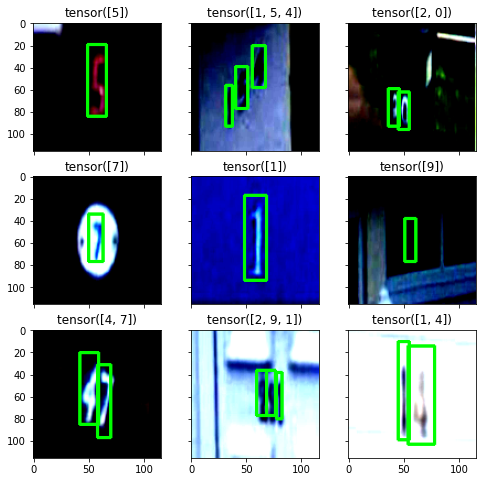

In [67]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random = int(np.random.uniform(0,1000))
    img,targ = train_dataset[random]
    img_label = targ['labels']
    img_box = targ['boxes']
    fig_x.imshow(draw_boxes(img_box,img_label,img))
    fig_x.set_title(str(img_label))

In [15]:
def fit_epoch(model, train_loader, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = list((input.float()).to(DEVICE) for input in inputs)
        labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in labels]
        optimizer.zero_grad()
        outputs = model(inputs, labels)
        loss = sum(x for x in outputs.values())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
    train_loss = running_loss / len(train_loader)
    return train_loss

In [16]:
def train(train_files, model, epochs, batch_size, model_name ='model'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers = 2, shuffle=True,collate_fn = collate_fn)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        params = [p for p in model.parameters() if p.requires_grad]
        opt = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)
#         lr_scheduler = torch.optim.lr_scheduler.StepLR(opt,
#                                                    step_size=7,
#                                                    gamma=0.6)    
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, opt)
#             lr_scheduler.step()
            history.append((train_loss))
            if train_loss<1:
                torch.save(model, './'+model_name+'.dat')
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss))
            
    return history

In [17]:
num_classes = 10
retina = models.detection.retinanet_resnet50_fpn(num_classes = num_classes, pretrained=False, pretrained_backbone = True)
retina.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [ ]:
history_1 = train(train_dataset, model=retina, epochs=25, batch_size=19, model_name = 'retinanet')

In [ ]:
history_2 = train(train_dataset, model=retina, epochs=10, batch_size=19, model_name = 'retinanet')

In [ ]:
history_3 = train(train_dataset, model=retina, epochs=7, batch_size=19, model_name = 'retinanet')

In [ ]:
history_4 = train(train_dataset, model=retina, epochs=13, batch_size=19, model_name = 'retinanet')

In [18]:
def predict_without_metrics(model,data,threshold=0.5):
    inputs = data
    idx_list=[]
    with torch.no_grad(): 
        model.eval()
        inputs = [inputs.to(DEVICE)]
        outputs = model(inputs)
        pred_boxes, pred_labels, scores = outputs[0]['boxes'],outputs[0]['labels'],outputs[0]['scores']
        for idx, score in enumerate(scores) :
            if score > threshold and idx not in idx_list:
                idx_list.append(idx)
    pred_boxes = pred_boxes[idx_list]
    pred_labels = pred_labels[idx_list]
    scores = scores[idx_list]
    return pred_boxes, pred_labels, scores

In [19]:
def calculate_metrics(model, dataset, number_samples = 0):
    if number_samples == 0:
        number_samples =len(dataset)
    iou =[]
    presicion = []
    recall = []
    map_m = []
    lost = 0
    with tqdm(desc="img", total=number_samples) as pbar_outer:
        for i in range(number_samples):
            data = dataset[i]
            inputs = data[0]
            labels = data[1]['labels']
            bboxes = data[1]['boxes']
            outputs = predict_without_metrics(model,inputs)
            iou_sample, presicion_sample, recall_sample,map_sample,l = metric_for_one_sample(outputs, (labels,bboxes))
            if -1 not in [iou_sample, presicion_sample, recall_sample, map_sample]:
                iou.append(iou_sample)
                presicion.append(recall_sample)
                recall.append(presicion_sample)
                map_m.append(map_sample)
            lost+=l
            pbar_outer.update(1)
    mean_map = np.mean(np.array(map_m))
    mean_iou = np.mean(np.array(iou))
    mean_presicion = np.mean(np.array(presicion))
    mean_recall = np.mean(np.array(recall))
    return mean_iou, mean_presicion, mean_recall,mean_map

In [20]:
def metric_for_one_sample(outputs, true_data, threshold=0.4):
    labels, bboxes = true_data
    pred_boxes, pred_labels, scores = outputs
    idx_list = []
    iou_all = []
    presicion_all = []
    recall_all = []
    not_find = 0
    if len(pred_boxes)>len(bboxes):
        pred_boxes = pred_boxes[:len(bboxes)]
        pred_labels=pred_labels[:len(bboxes)]
    elif len(pred_boxes)<len(bboxes):
        not_find += len(bboxes)-len(pred_boxes)
     # считаем метрики   
    map_m = MAP(bboxes, pred_boxes, scores)
    for item1 in pred_boxes:
        help_iou= []
        help_presicion =[]
        help_recall=[]
        for item2 in bboxes:
            iou, presicion, recall = calculate_iou_precision_recall(item2,item1)
            help_iou.append(iou)
            help_presicion.append(presicion)
            help_recall.append(recall)
        iou_all.append(help_iou)
        presicion_all.append(help_presicion)
        recall_all.append(help_recall)
    iou_all = np.array([[item.detach().cpu().numpy() for item in items] for items in iou_all])
    presicion_all = np.array([[item.detach().cpu().numpy() for item in items] for items in presicion_all])
    recall_all =  np.array([[item.detach().cpu().numpy() for item in items] for items in recall_all])
    # получили матрицы: количество предсказанных значений * количествоистинных значений 
    if iou_all.size > 0:
        idxx = np.argmax(iou_all, axis=1)
        return np.mean(np.max(iou_all, axis=1)), np.mean(np.array([presicion_all[i][idxx[i]] for i in range(len(presicion_all))])),np.mean(np.array([recall_all[i][idxx[i]] for i in range(len(recall_all))])), map_m,not_find
    else: 
        return -1,-1,-1,-1,not_find

In [21]:
def calculate_iou_precision_recall(bbox1, bbox2, return_pr = True):
    # bbox1 - target
    # bbox2 - pred
    x_overlap = max(0, min(bbox1[2], bbox2[2]) - max(bbox1[0], bbox2[0]))
    y_overlap = max(0, min(bbox1[3], bbox2[3]) - max(bbox1[1], bbox2[1]))
    intersection = x_overlap * y_overlap

    area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    union = area1 + area2 - intersection
    if return_pr:
        return intersection / union, intersection / area2, intersection / area1
    else: return intersection / union
    
def MAP(boxes_true, boxes_pred, scores, thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    map_total = 0
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = calculate_iou_precision_recall(bt, bp, return_pr = False)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN
                
        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m
    
    return map_total / len(thresholds)

In [71]:
def test(model, df):
    for i in range(len(df)):
        image = Image.open('../input/my-nums/' + df['file'][i]).convert("RGB")
        transforms = T.Compose([T.ToTensor(),
                         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        image = image.resize((RESCALE_SIZE_1, RESCALE_SIZE_2))
        x = image
        x = np.array(x, dtype='float32')/ 255
        x = transforms(x)
        fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 10), \
                        sharey=True, sharex=True)
        pred_box, pred_label,pred_score = predict_without_metrics(retina,x,threshold=0.5)
        k=0
        for fig_x in ax.flatten():      
            if k ==0:
                fig_x.imshow(image)
                fig_x.set_title('y_true')
            else:
                fig_x.imshow(draw_boxes(pred_box,pred_label,x))
                fig_x.set_title('y_pred'+str(pred_label.detach().cpu().numpy()))
            k+=1
    plt.show()

In [58]:
retina = torch.load('../input/newnum/retinanetnumnew.dat')

In [59]:
test_dataset = SignDataset(test_df['names'], test_df, mode = 'test')
iou, presicion, recall, map_m = calculate_metrics(retina, test_dataset, number_samples = 300)
print('iou: ', iou)
print('presicion: ', presicion)
print('recall: ', recall)
print('map_m: ', map_m)

img: 100%|██████████| 300/300 [00:20<00:00, 14.62it/s]

iou:  0.69080395
presicion:  0.81902593
recall:  0.82777
map_m:  0.6538834154351396


In [51]:
my_test_df = pd.DataFrame()
my_test_df['file'] = os.listdir('../input/my-nums')

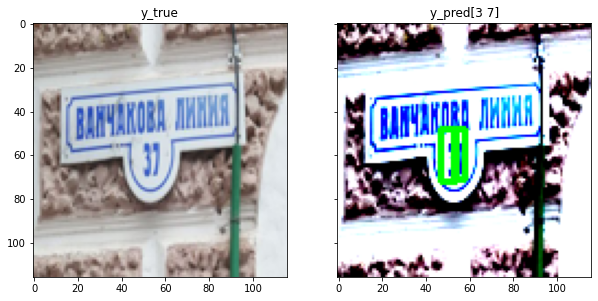

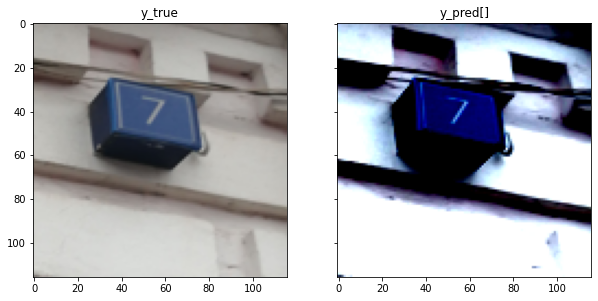

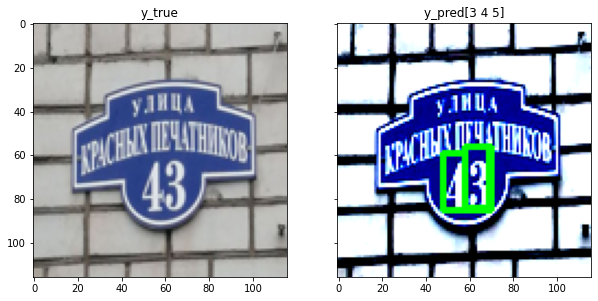

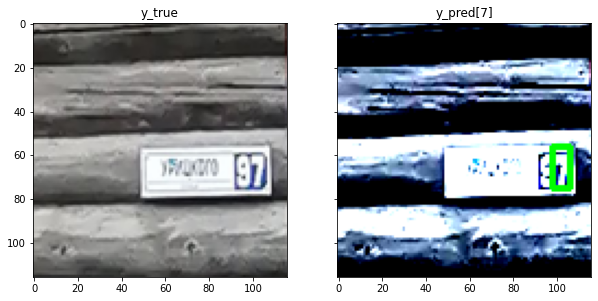

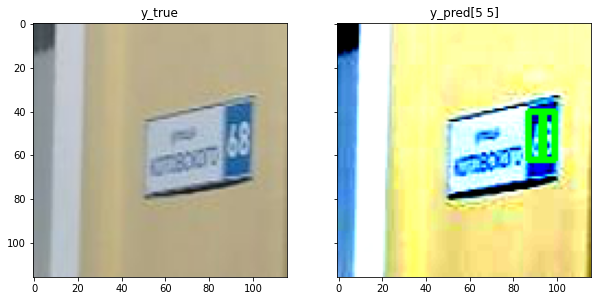

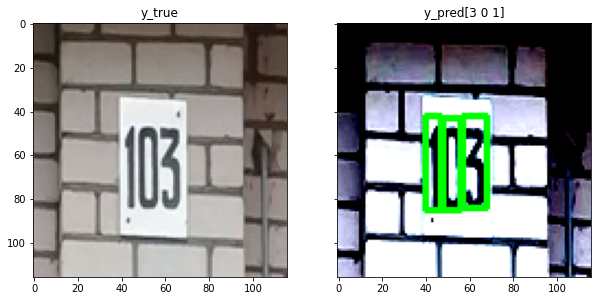

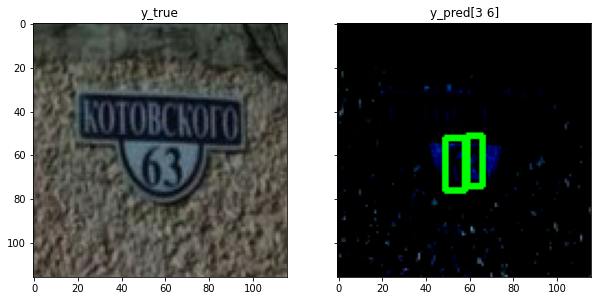

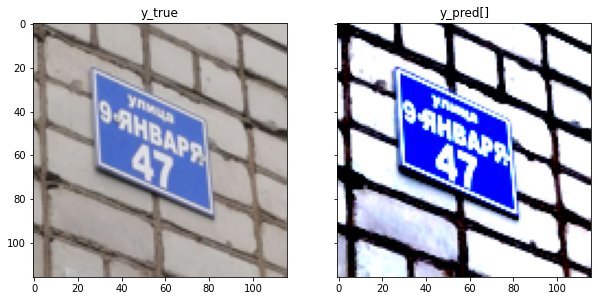

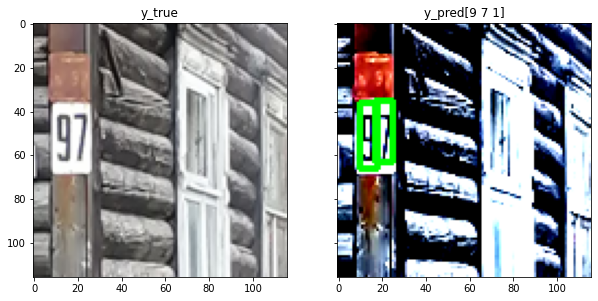

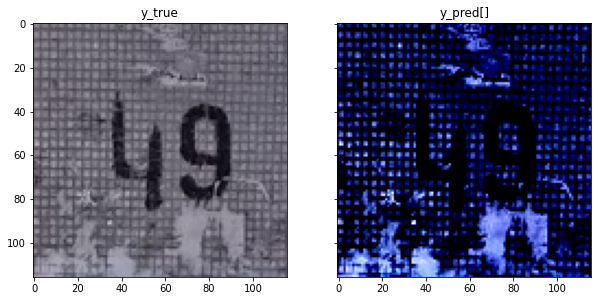

In [72]:
test(retina, my_test_df)